Combined data for main spending categories (2006-2020):
                                              Item     2006     2007     2008  \
0                      Average Annual Expenditures  48400.0  49638.0  50486.0   
1                                             Food   6111.0   6133.0   6443.0   
2                              Alcoholic beverages    497.0    457.0    444.0   
3                                          Housing  16366.0  16920.0  17109.0   
4                             Apparel and services   1874.0   1881.0   1801.0   
5                                   Transportation   8508.0   8758.0   8604.0   
6                                       Healthcare   2766.0   2853.0   2976.0   
7                                    Entertainment   2377.0   2698.0   2835.0   
8              Personal care products and services    585.0    588.0    616.0   
9                                          Reading    117.0    118.0    116.0   
10                                       Education   

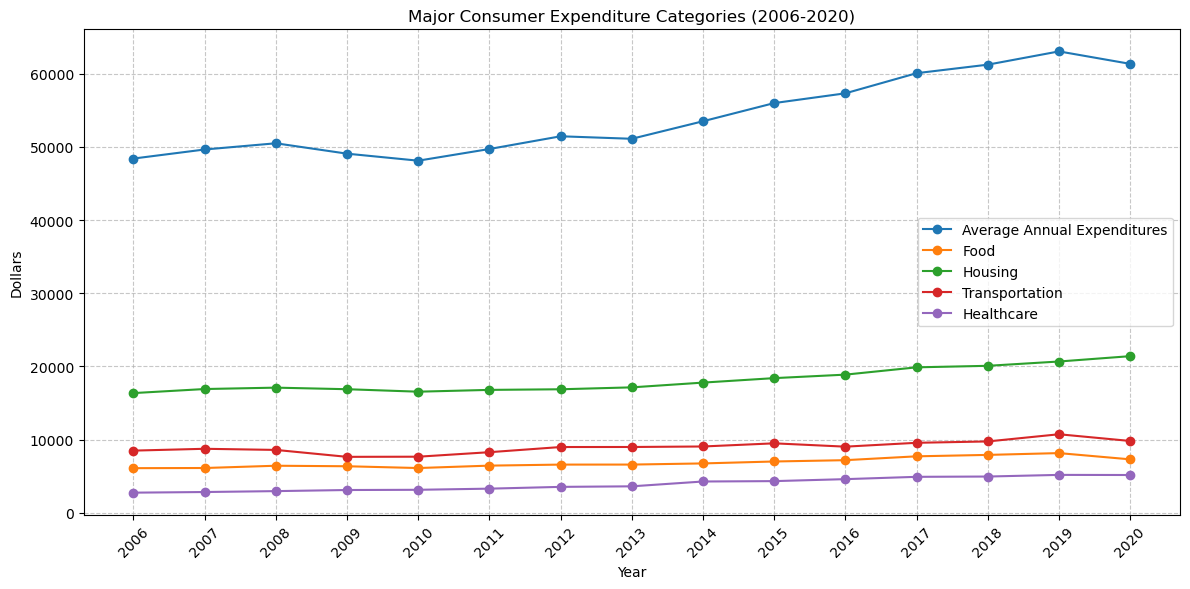

Created visualization 'consumer_spending_trends.png'

Percentage change in spending from 2006 to 2020:
Average Annual Expenditures: 26.72%
Food: 19.72%
Housing: 30.81%
Transportation: 15.49%
Healthcare: 87.17%


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to read and clean the CSV files
def read_and_clean_csv(filename):
    # Read the CSV file
    df = pd.read_csv(filename)
    
    # Clean column names by stripping quotes and whitespace
    df.columns = df.columns.str.strip('"').str.strip()
    
    # For the first column, remove quotation marks and whitespace
    df.iloc[:, 0] = df.iloc[:, 0].str.strip('"').str.strip() if df.iloc[:, 0].dtype == 'object' else df.iloc[:, 0]
    
    return df

# Function to extract main categories
def extract_main_categories(df):
    # Identify main categories by finding rows that come right after blank rows
    # First, identify blank rows (rows where the first column is empty or NaN)
    blank_rows = df.iloc[:, 0].isna() | (df.iloc[:, 0] == '')
    
    # Find rows that come right after blank rows
    main_category_indices = []
    for i in range(1, len(blank_rows)):
        if blank_rows[i-1] and not blank_rows[i]:
            main_category_indices.append(i)
    
    # Also include the first row (which contains "Average Annual Expenditure")
    if not blank_rows[0]:
        main_category_indices.insert(0, 0)
    
    # Extract main categories and their data
    main_categories_df = df.iloc[main_category_indices].copy()
    
    return main_categories_df

# Read and clean the CSV files
df1 = read_and_clean_csv('../data/original/consumer06csv.csv')
df2 = read_and_clean_csv('../data/original/consumer13csv.csv')

# Extract main categories from each file
main_categories_df1 = extract_main_categories(df1)
main_categories_df2 = extract_main_categories(df2)

# Convert dollar values to numeric, removing $ and commas
def clean_dollar_values(df):
    for col in df.columns[1:]:  # Skip the first column (Item)
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace('$', '', regex=False)
            df[col] = df[col].str.replace(',', '', regex=False)
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

main_categories_df1 = clean_dollar_values(main_categories_df1)
main_categories_df2 = clean_dollar_values(main_categories_df2)

# Combine the two dataframes
# First, prepare the dataframes by setting the 'Item' column as index
main_categories_df1.set_index('Item', inplace=True)
main_categories_df2.set_index('Item', inplace=True)

# Now combine them
combined_df = pd.concat([main_categories_df1, main_categories_df2], axis=1)

# Reset index to make 'Item' a column again
combined_df.reset_index(inplace=True)

# Display the combined dataframe
print("Combined data for main spending categories (2006-2020):")
print(combined_df)

# Save the combined data to a new CSV file
combined_df.to_csv('combined_consumer_spending_2006_2020.csv', index=False)
print("\nData saved to 'combined_consumer_spending_2006_2020.csv'")

# Let's also create a visualization for one of the main categories over time
plt.figure(figsize=(12, 6))

# Select a few interesting categories to plot
categories_to_plot = ['Average Annual Expenditures', 'Food', 'Housing', 'Transportation', 'Healthcare']

for category in categories_to_plot:
    # Find the row for this category
    if category in combined_df['Item'].values:
        row = combined_df[combined_df['Item'] == category]
        # Extract year columns and values
        years = [col for col in row.columns if col != 'Item']
        values = row.iloc[0, 1:].values
        plt.plot(years, values, marker='o', label=category)

plt.title('Major Consumer Expenditure Categories (2006-2020)')
plt.xlabel('Year')
plt.ylabel('Dollars')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('consumer_spending_trends.png')
plt.show()

print("Created visualization 'consumer_spending_trends.png'")

# Let's analyze the percentage change in major categories from 2006 to 2020
if 'Item' in combined_df.columns and '2006' in combined_df.columns and '2020' in combined_df.columns:
    print("\nPercentage change in spending from 2006 to 2020:")
    for category in categories_to_plot:
        if category in combined_df['Item'].values:
            row = combined_df[combined_df['Item'] == category]
            val_2006 = row['2006'].values[0]
            val_2020 = row['2020'].values[0]
            percent_change = ((val_2020 - val_2006) / val_2006) * 100
            print(f"{category}: {percent_change:.2f}%")

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv('combined_consumer_spending_2006_2020.csv')

# Clean up the data first by removing rows that contain summaries or non-spending categories
# We'll keep only the main spending categories
main_categories = [
    'Average Annual Expenditures', 'Food', 'Alcoholic beverages', 'Housing', 
    'Apparel and services', 'Transportation', 'Healthcare', 'Entertainment',
    'Personal care products and services', 'Reading', 'Education', 
    'Tobacco products and smoking supplies', 'Miscellaneous',
    'Cash contributions', 'Personal insurance and pensions'
]

# Filter the dataframe to keep only the main spending categories
df_clean = df[df['Item'].isin(main_categories)]

# Now melt the dataframe to convert from wide to long format
df_long = pd.melt(
    df_clean,
    id_vars=['Item'],  # Keep 'Item' as an identifier
    value_vars=[str(year) for year in range(2006, 2021)],  # Years 2006-2020 as variables
    var_name='Year',  # Name for the new column containing years
    value_name='Spending'  # Name for the new column containing spending values
)

# Convert Year to integer and Spending to float
df_long['Year'] = df_long['Year'].astype(int)
df_long['Spending'] = pd.to_numeric(df_long['Spending'], errors='coerce')

# Display the first few rows of the transformed data
print(df_long.head(10))

# Save the transformed data to a new CSV file
df_long.to_csv('consumer_spending_long_format.csv', index=False)

print(f"Data successfully transformed and saved to 'consumer_spending_long_format.csv'")

                                  Item  Year  Spending
0          Average Annual Expenditures  2006   48400.0
1                                 Food  2006    6111.0
2                  Alcoholic beverages  2006     497.0
3                              Housing  2006   16366.0
4                 Apparel and services  2006    1874.0
5                       Transportation  2006    8508.0
6                           Healthcare  2006    2766.0
7                        Entertainment  2006    2377.0
8  Personal care products and services  2006     585.0
9                              Reading  2006     117.0
Data successfully transformed and saved to 'consumer_spending_long_format.csv'


In [66]:
df_long.sample(20)

,Item,Year,Spending
112,Entertainment,2013,2482.0
53,Personal care products and services,2009,596.0
153,Housing,2016,18886.0
178,Cash contributions,2017,1873.0
62,Alcoholic beverages,2010,412.0
90,Average Annual Expenditures,2012,51442.0
37,Entertainment,2008,2835.0
120,Average Annual Expenditures,2014,53495.0
184,Apparel and services,2018,1866.0
19,Apparel and services,2007,1881.0


Dataset Overview:
Shape: (225, 3)

First few rows:
                          Item  Year  Spending
0  Average Annual Expenditures  2006   48400.0
1                         Food  2006    6111.0
2          Alcoholic beverages  2006     497.0
3                      Housing  2006   16366.0
4         Apparel and services  2006    1874.0

Summary statistics for spending:
count      225.000000
mean      7203.471111
std      13441.084314
min         92.000000
25%        683.000000
50%       1874.000000
75%       6759.000000
max      63036.000000
Name: Spending, dtype: float64

Total expenditures by year:
     Year  Spending
0    2006   48400.0
15   2007   49638.0
30   2008   50486.0
45   2009   49067.0
60   2010   48109.0
75   2011   49705.0
90   2012   51442.0
105  2013   51100.0
120  2014   53495.0
135  2015   55978.0
150  2016   57311.0
165  2017   60060.0
180  2018   61224.0
195  2019   63036.0
210  2020   61334.0

Percentage change in total expenditures year-over-year:
     Year  Spending 

/var/folders/1x/zwvq_9c13nd4s2lk8pdz1nrw0000gn/T/ipykernel_16350/3497999071.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_expenditures['Pct_Change'] = total_expenditures['Spending'].pct_change() * 100


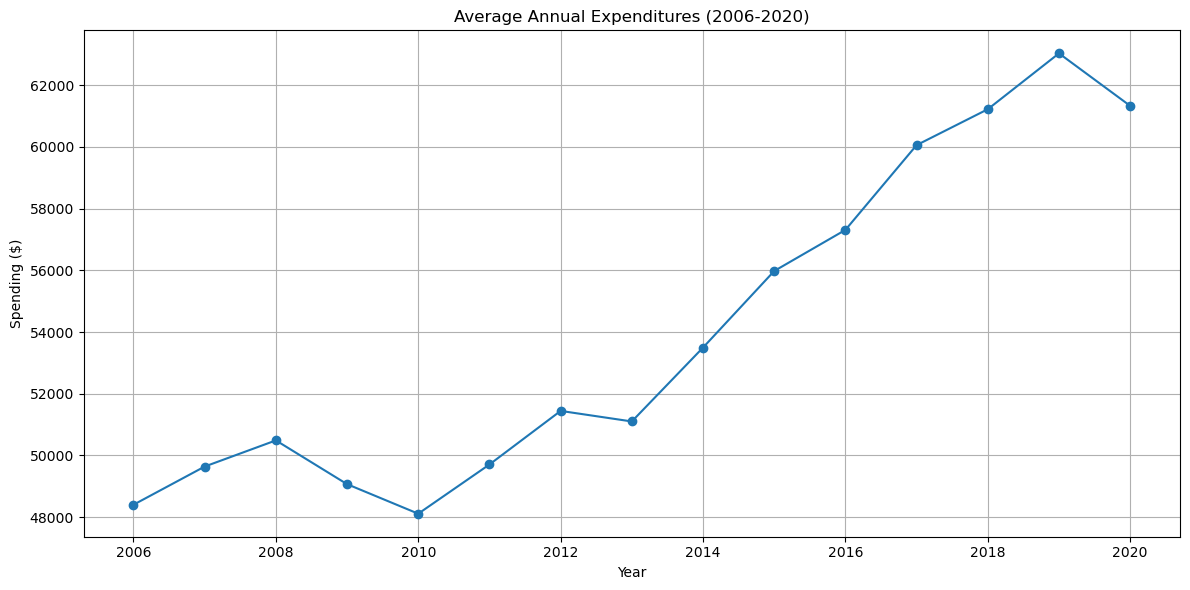

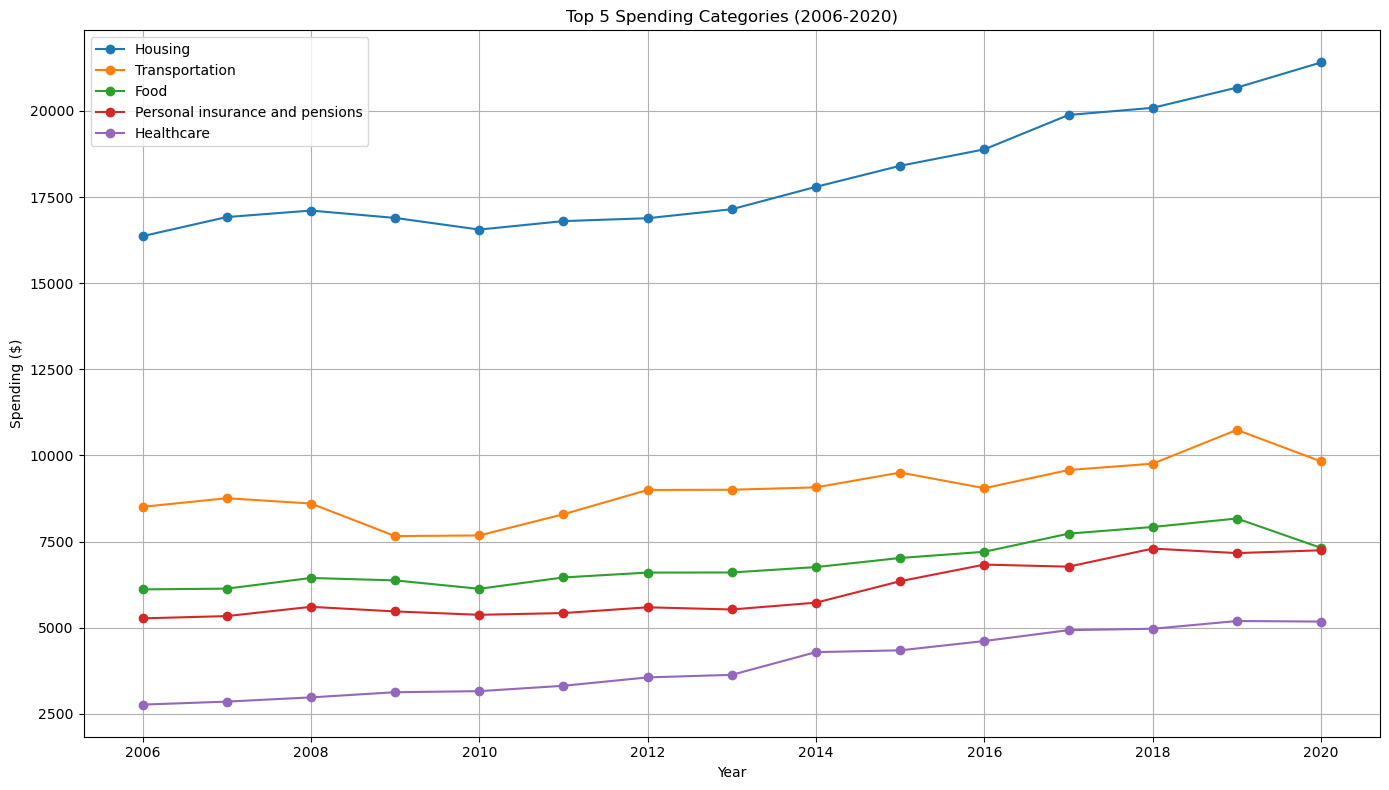

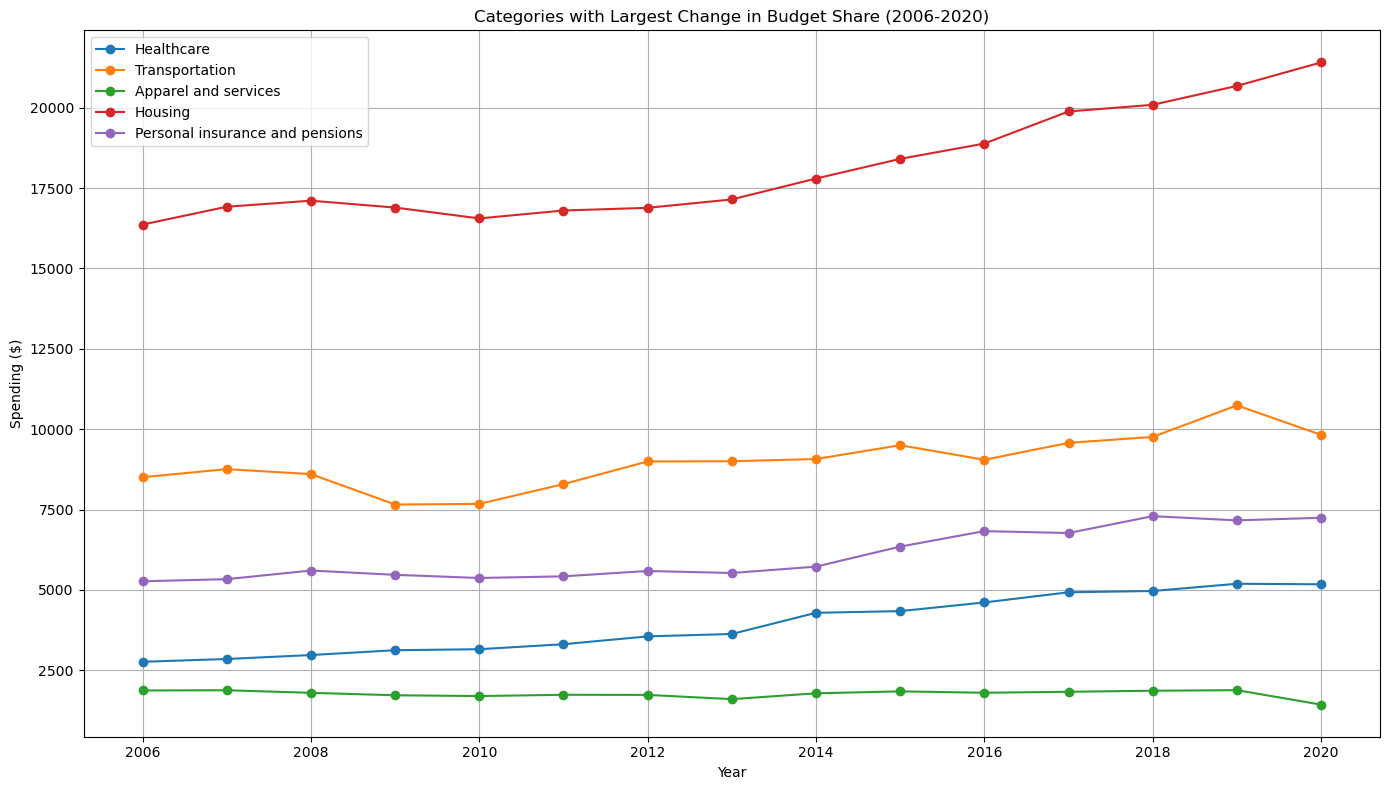

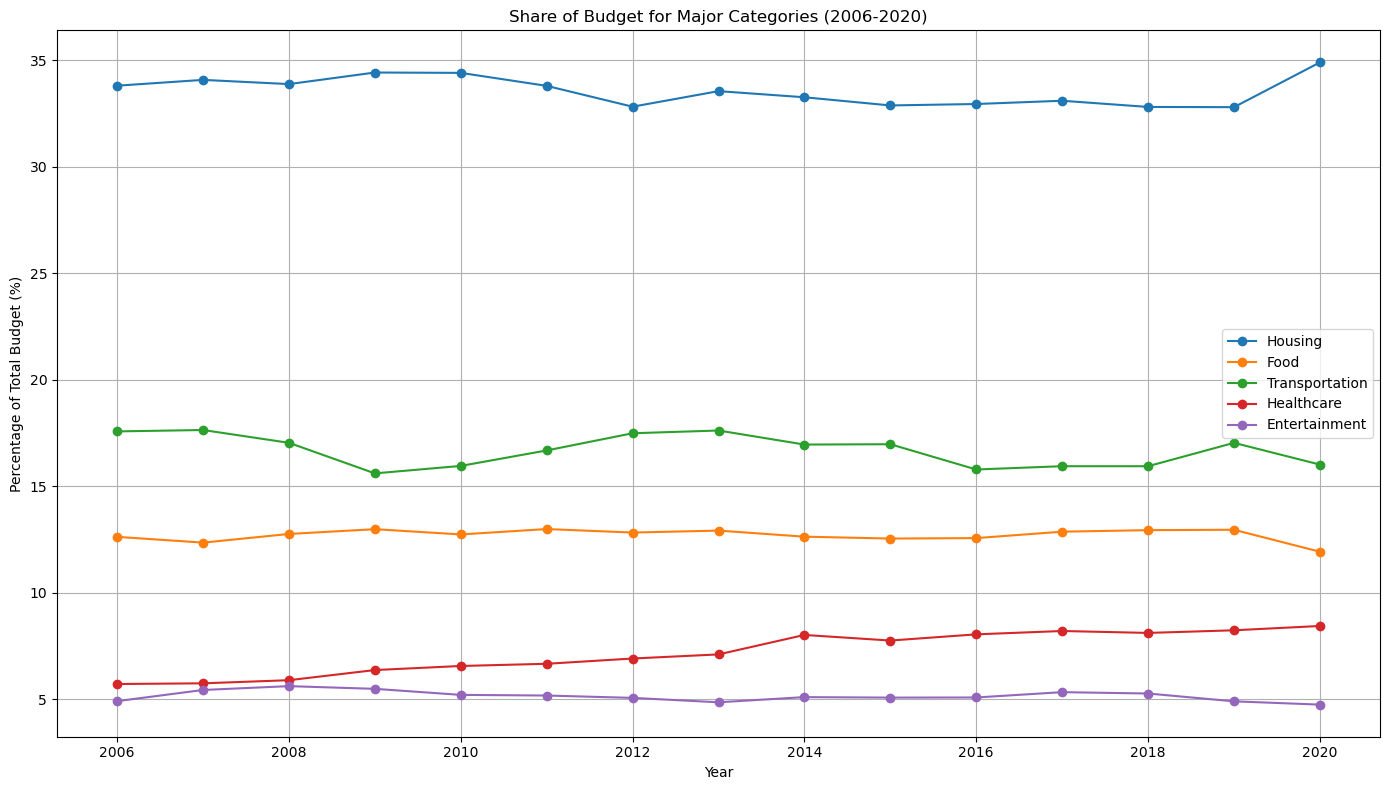

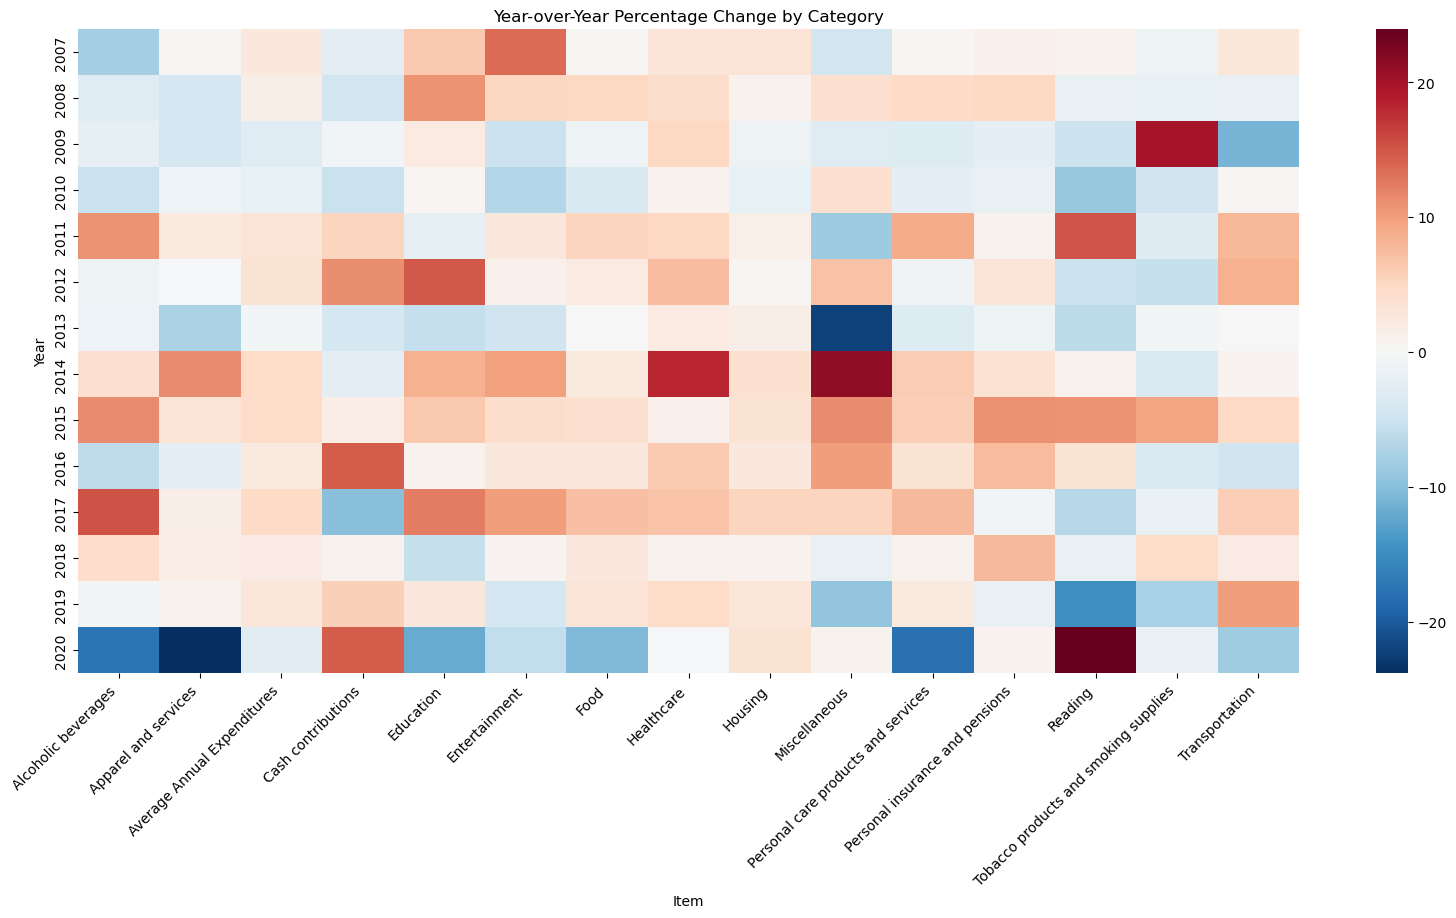

/var/folders/1x/zwvq_9c13nd4s2lk8pdz1nrw0000gn/T/ipykernel_16350/3497999071.py:167: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '445.6021596357629' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  inflation_adj.loc[inflation_adj['Year'] == year, f"{category}_adj"] = category_value * inflation_factor
/var/folders/1x/zwvq_9c13nd4s2lk8pdz1nrw0000gn/T/ipykernel_16350/3497999071.py:167: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1834.086788347637' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  inflation_adj.loc[inflation_adj['Year'] == year, f"{category}_adj"] = category_value * inflation_factor
/var/folders/1x/zwvq_9c13nd4s2lk8pdz1nrw0000gn/T/ipykernel_16350/3497999071.py:167: FutureWarning: Setting an item of incompatible dtype is deprecated


Real growth rates (adjusted for overall expenditure growth):
Alcoholic beverages: -24.10%
Apparel and services: -39.62%
Cash contributions: -3.61%
Education: 12.95%
Entertainment: -3.33%
Food: -5.53%
Healthcare: 47.70%
Housing: 3.23%
Miscellaneous: -15.40%
Personal care products and services: -12.86%
Personal insurance and pensions: 8.50%
Reading: -23.11%
Tobacco products and smoking supplies: -23.98%
Transportation: -8.86%


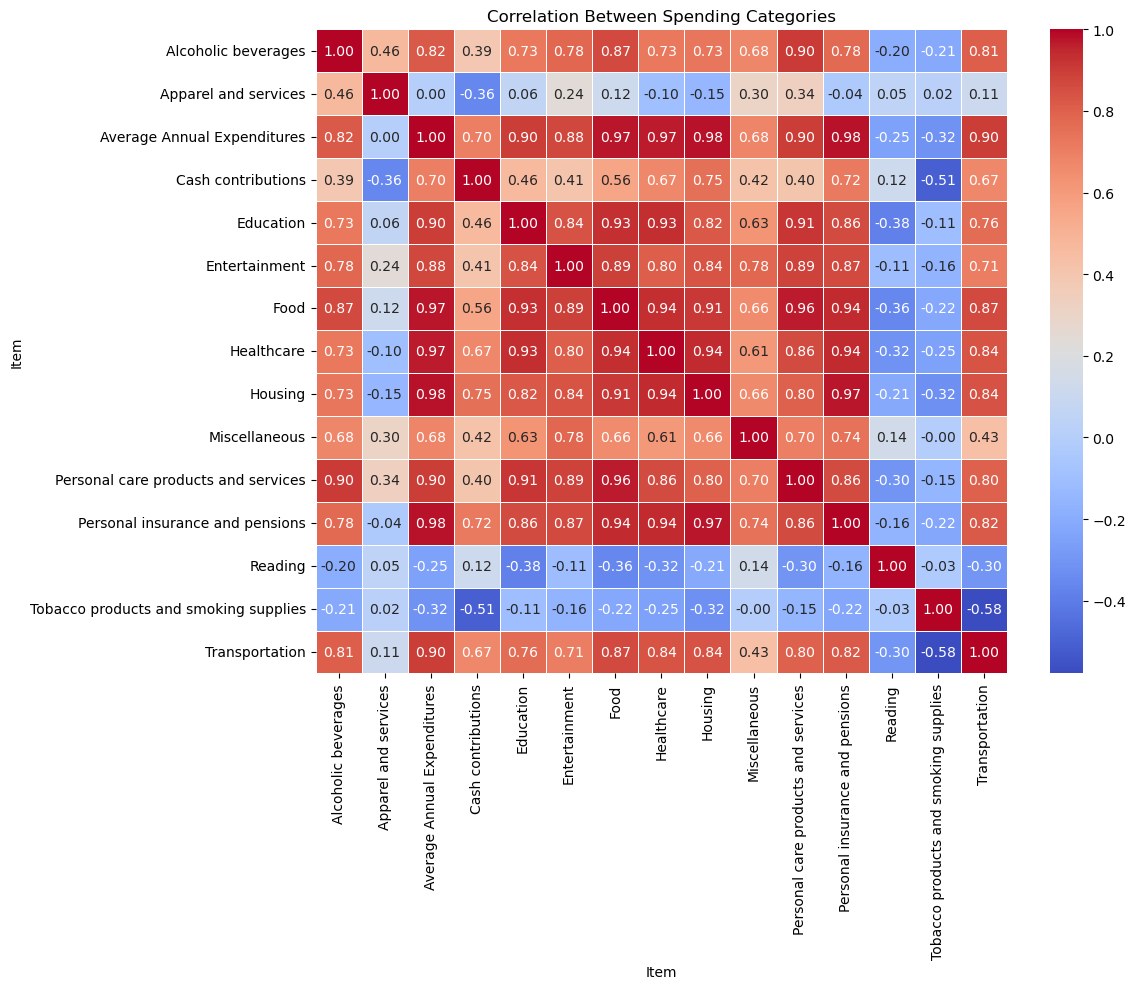

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the CSV file
def read_csv_data():
    # Using window.fs.readFile for browser environment or fallback to direct reading
    try:
        import io
        file_content = window.fs.readFile('../data/processed/consumer_spending_long_format.csv', {'encoding': 'utf8'})
        return pd.read_csv(io.StringIO(file_content))
    except:
        # Fallback for local testing
        return pd.read_csv('../data/processed/consumer_spending_long_format.csv')

# Load the data
df = read_csv_data()

# Display basic information about the dataset
print("Dataset Overview:")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# Calculate summary statistics
print("\nSummary statistics for spending:")
print(df['Spending'].describe())

# Analyze trends for total expenditures over time
total_expenditures = df[df['Item'] == 'Average Annual Expenditures']
print("\nTotal expenditures by year:")
print(total_expenditures[['Year', 'Spending']])

# Calculate percentage change year over year for total expenditures
total_expenditures['Pct_Change'] = total_expenditures['Spending'].pct_change() * 100
print("\nPercentage change in total expenditures year-over-year:")
print(total_expenditures[['Year', 'Spending', 'Pct_Change']])

# Analyze trends by category over time
# Get unique items excluding the total
categories = sorted(df['Item'].unique().tolist())
categories.remove('Average Annual Expenditures')

# Calculate percent of total budget for each category
df_pivot = df.pivot(index='Year', columns='Item', values='Spending').reset_index()

# Create a dataframe for percentage analysis
percent_df = pd.DataFrame()
percent_df['Year'] = df_pivot['Year']

for category in categories:
    percent_df[category] = (df_pivot[category] / df_pivot['Average Annual Expenditures']) * 100

# Find the categories with the largest changes over time
first_year = percent_df['Year'].min()
last_year = percent_df['Year'].max()

category_changes = {}
for category in categories:
    first_value = percent_df[percent_df['Year'] == first_year][category].values[0]
    last_value = percent_df[percent_df['Year'] == last_year][category].values[0]
    change = last_value - first_value
    category_changes[category] = change

# Sort categories by absolute change
sorted_changes = sorted(category_changes.items(), key=lambda x: abs(x[1]), reverse=True)
print("\nCategories with the largest change in budget percentage (2006 to 2020):")
for category, change in sorted_changes[:5]:
    print(f"{category}: {change:.2f}% change")

# Calculate compound annual growth rate (CAGR) for each category
cagr_results = {}
years_diff = last_year - first_year

for category in categories:
    first_value = df[(df['Year'] == first_year) & (df['Item'] == category)]['Spending'].values[0]
    last_value = df[(df['Year'] == last_year) & (df['Item'] == category)]['Spending'].values[0]
    cagr = (last_value / first_value) ** (1 / years_diff) - 1
    cagr_results[category] = cagr * 100

# Sort categories by CAGR
sorted_cagr = sorted(cagr_results.items(), key=lambda x: x[1], reverse=True)
print("\nCategories by Compound Annual Growth Rate (CAGR):")
for category, cagr in sorted_cagr:
    print(f"{category}: {cagr:.2f}%")

# Visualizations
plt.figure(figsize=(12, 6))
plt.plot(total_expenditures['Year'], total_expenditures['Spending'], marker='o')
plt.title('Average Annual Expenditures (2006-2020)')
plt.xlabel('Year')
plt.ylabel('Spending ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot top 5 categories by spending in 2020
top_categories_2020 = df[df['Year'] == 2020].sort_values('Spending', ascending=False)['Item'].unique()[:6]
top_categories_2020 = [cat for cat in top_categories_2020 if cat != 'Average Annual Expenditures']

plt.figure(figsize=(14, 8))
for category in top_categories_2020:
    category_data = df[df['Item'] == category]
    plt.plot(category_data['Year'], category_data['Spending'], marker='o', label=category)
plt.title('Top 5 Spending Categories (2006-2020)')
plt.xlabel('Year')
plt.ylabel('Spending ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot categories with the biggest percentage changes
biggest_change_categories = [cat for cat, _ in sorted_changes[:5]]
plt.figure(figsize=(14, 8))
for category in biggest_change_categories:
    category_data = df[df['Item'] == category]
    plt.plot(category_data['Year'], category_data['Spending'], marker='o', label=category)
plt.title('Categories with Largest Change in Budget Share (2006-2020)')
plt.xlabel('Year')
plt.ylabel('Spending ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the share of budget over time for major categories
major_categories = ['Housing', 'Food', 'Transportation', 'Healthcare', 'Entertainment']
plt.figure(figsize=(14, 8))
for category in major_categories:
    plt.plot(percent_df['Year'], percent_df[category], marker='o', label=category)
plt.title('Share of Budget for Major Categories (2006-2020)')
plt.xlabel('Year')
plt.ylabel('Percentage of Total Budget (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Create a heatmap showing the year-over-year percentage change for all categories
yearly_pct_change = df.pivot(index='Year', columns='Item', values='Spending').pct_change() * 100

plt.figure(figsize=(16, 10))
sns.heatmap(yearly_pct_change.iloc[1:], cmap='RdBu_r', center=0, annot=False)
plt.title('Year-over-Year Percentage Change by Category')
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

# Calculate inflation-adjusted spending (using total expenditure as a reference)
# This gives us a sense of which categories increased faster or slower than overall spending
inflation_adj = pd.DataFrame()
inflation_adj['Year'] = df_pivot['Year']

base_year = first_year
base_total = df_pivot[df_pivot['Year'] == base_year]['Average Annual Expenditures'].values[0]

for year in df_pivot['Year'].unique():
    inflation_factor = base_total / df_pivot[df_pivot['Year'] == year]['Average Annual Expenditures'].values[0]
    
    for category in categories:
        if f"{category}_adj" not in inflation_adj.columns:
            inflation_adj[f"{category}_adj"] = 0
        
        category_value = df_pivot[df_pivot['Year'] == year][category].values[0]
        inflation_adj.loc[inflation_adj['Year'] == year, f"{category}_adj"] = category_value * inflation_factor

# Calculate real growth rates (adjusted for overall expenditure growth)
print("\nReal growth rates (adjusted for overall expenditure growth):")
for category in categories:
    first_value = inflation_adj[inflation_adj['Year'] == first_year][f"{category}_adj"].values[0]
    last_value = inflation_adj[inflation_adj['Year'] == last_year][f"{category}_adj"].values[0]
    real_growth = ((last_value / first_value) - 1) * 100
    print(f"{category}: {real_growth:.2f}%")

# Create a correlation matrix to see how spending in different categories moves together
correlation_matrix = df_pivot.drop('Year', axis=1).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Spending Categories')
plt.tight_layout()
plt.show()